In [ ]:
!pip install dvc

In [ ]:
!dvc get https://github.com/iterative/aita_dataset aita_clean.csv

In [ ]:
import pandas as pd

df = pd.read_csv("aita_clean.csv")
df.tail()

,id,timestamp,title,body,edited,verdict,score,num_comments,is_asshole
97623,ex94w5,1.580577e+09,AITA for telling my sister she is being a spoi...,My sister(17F) and I(15M) are white kids born ...,1580585457.0,not the asshole,16,23.0,0
97624,ex970f,1.580577e+09,AITA for telling my husband to f* off after he...,My husband (28M) and I (32F) are married for a...,1580584475.0,not the asshole,1373,304.0,0
97625,ex9dwo,1.580578e+09,AITA for attempting to keep my students out of...,Upfront apologies for formatting. I’m also try...,False,not the asshole,4,15.0,0
97626,ex9egs,1.580578e+09,WIBTA if I left my brothers fate up to the state?,A little back story my mom is a drug addict an...,False,not the asshole,280,140.0,0
97627,ex9g78,1.580578e+09,WIBTA for rocking the boat at work because my ...,I’m a (23F) apprentice in the trades. I work o...,False,not the asshole,5,21.0,0


In [ ]:
# filtering posts with scores >= 10
df_filtered = df[df['score'] >= 10]
df_filtered.to_csv('aita_filtered.csv')

In [ ]:
df = pd.read_csv("aita_filtered.csv")
df.tail()

,Unnamed: 0,id,timestamp,title,body,edited,verdict,score,num_comments,is_asshole
48848,97620,ex8v2t,1.580576e+09,AITA for wanting to go out on my birthday,I recently lost my legs so I haven't been out ...,False,not the asshole,11,17.0,0
48849,97621,ex8ys3,1.580576e+09,AITA for yelling at my daughter?,"\nI(46,M) have been helping my(17,F) daughter ...",False,asshole,67,54.0,1
48850,97623,ex94w5,1.580577e+09,AITA for telling my sister she is being a spoi...,My sister(17F) and I(15M) are white kids born ...,1580585457.0,not the asshole,16,23.0,0
48851,97624,ex970f,1.580577e+09,AITA for telling my husband to f* off after he...,My husband (28M) and I (32F) are married for a...,1580584475.0,not the asshole,1373,304.0,0
48852,97626,ex9egs,1.580578e+09,WIBTA if I left my brothers fate up to the state?,A little back story my mom is a drug addict an...,False,not the asshole,280,140.0,0


In [ ]:
# combining title and body fields
df['text'] = df["title"] + df["body"].fillna("")

# CLASS FREQUENCIES

In [ ]:
counts = df['verdict'].value_counts()
verdict = counts.index.to_list()
freq = counts.to_list()
freq_df = pd.DataFrame(list(zip(verdict, freq)), 
               columns =['Verdict', 'Frequency']) 
freq_df['Verdict'] = freq_df['Verdict'].str.title()
freq_df.head()

,Verdict,Frequency
0,Not The Asshole,30406
1,Asshole,10928
2,No Assholes Here,5090
3,Everyone Sucks,2429


No handles with labels found to put in legend.


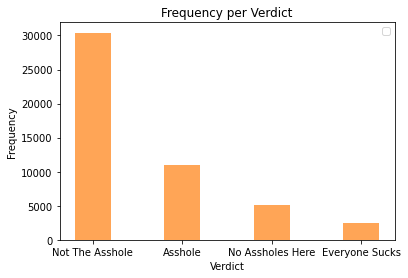

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

labels = freq_df.Verdict

index = np.arange(len(labels)) # Keep a numeric index for the x-axis lables
fig, ax = plt.subplots()

bar_width = 0.4
opacity = 0.7

rects = ax.bar(index, freq_df.Frequency, bar_width,
                alpha=opacity, color='tab:orange')

# Make the style nice and add labels.
ax.set_xlabel('Verdict')
ax.set_ylabel('Frequency')
ax.set_title('Frequency per Verdict')

ax.set_xticks(index )
ax.set_xticklabels(labels)
ax.legend()

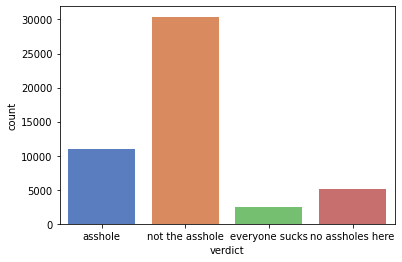

In [ ]:
# Visualise your data in a few useful graphs (up to you to think about what would be useful)

import seaborn as sns
#breakdown by class
sns.countplot(x="verdict", data=df, palette="muted", dodge=False);
h,l = ax.get_legend_handles_labels()
labels=["Not The A-hole", "A-hole", "No A-holes Here", "Everyone Sucks Here"]
ax.legend(h,labels,title="Verdict", loc="upper right") 

plt.show()

# TF-IDF VECTORIZER WITH CHI2
To determine the most informative words in the posts with respect to the class attribute

In [ ]:
# FEATURE SELECTION
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2

vec = TfidfVectorizer(ngram_range=(1,1),max_features=10000)
vec_text = vec.fit_transform(df.text)
chi2_score = chi2(vec_text, df.is_asshole)[0]

In [ ]:
# getting words with top chi2 scores
word_scores = zip(vec.get_feature_names_out(), chi2_score)
word_chi2 = sorted(word_scores, key = lambda x:x[1])
top10 = word_chi2[-10:]
print(top10) # get words with tops 10 chi2 scores

[('she', 9.100005475747716), ('parents', 9.717077248619272), ('mum', 10.930872772653233), ('daughter', 11.279285639857598), ('girlfriend', 12.552855069077893), ('my', 16.789328599251206), ('dad', 17.64842717373996), ('mother', 19.28423821195917), ('wife', 30.731215585329117), ('mom', 31.26898509023862)]


In [16]:
# Calculate log odds for each
import numpy as np

# filtering rows which have certain word
df['has_father'] = df['text'].str.contains("father|dad", case=False)
df['has_mother'] = df['text'].str.contains("mother|mum|mom", case=False)
df['has_son'] = df['text'].str.contains("son", case=False)
df['has_daughter'] = df['text'].str.contains("daughter", case=False)
df['has_husband'] = df['text'].str.contains("husband|boyfriend|bf", case=False)
df['has_wife'] = df['text'].str.contains("wife|girlfriend|gf", case=False)

# filtering rows which are asshole/not asshole
yes_asshole = df[ df['is_asshole']==1 ]
not_asshole = df[ df['is_asshole']==0 ]

# getting log odds
logOdds_father = np.log2( np.mean(yes_asshole['has_father']) / np.mean(not_asshole['has_father']) )
logOdds_mother = np.log2( np.mean(yes_asshole['has_mother']) / np.mean(not_asshole['has_mother']) )
logOdds_son = np.log2( np.mean(yes_asshole['has_son']) / np.mean(not_asshole['has_son']) )
logOdds_daughter = np.log2( np.mean(yes_asshole['has_daughter']) / np.mean(not_asshole['has_daughter']) )
logOdds_husband = np.log2( np.mean(yes_asshole['has_husband']) / np.mean(not_asshole['has_husband']) )
logOdds_wife = np.log2( np.mean(yes_asshole['has_wife']) / np.mean(not_asshole['has_wife']) )

term = ["Dad", "Mum", "Son", "Daughter", "Husband/BF", "Wife/GF"]
logOdds = [logOdds_father, logOdds_mother, logOdds_son, logOdds_daughter, logOdds_husband, logOdds_wife]
logOdds_df = pd.DataFrame(zip(term, logOdds), columns=["word","logOdds"])

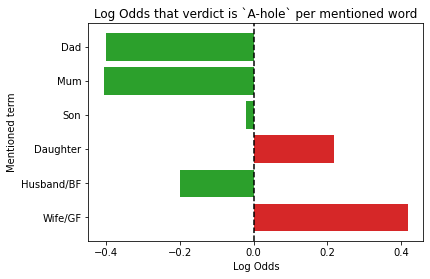

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

term = logOdds_df.word
logOdds = logOdds_df.logOdds

fig, ax = plt.subplots()
plt.rcdefaults()

y_pos = np.arange(len(term))

threshold = 0
above_threshold = np.maximum(logOdds - threshold, 0)
below_threshold = np.minimum(logOdds, threshold)

ax.barh(y_pos, below_threshold,  color="tab:green")
ax.barh(y_pos, above_threshold, color="tab:red")
ax.set_yticks(y_pos)
ax.set_yticklabels(term)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Log Odds')
ax.set_ylabel('Mentioned term')
ax.set_title('Log Odds that verdict is `A-hole` per mentioned word')

# horizontal line indicating the threshold
plt.axvline(x=0, color='k', linestyle='--')